In [1]:
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Input, GlobalAveragePooling1D
from keras.layers import Flatten, Dot
from keras.layers.embeddings import Embedding
from keras.models import Model
from umap import UMAP
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import pickle, random

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/home/j/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/j/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/j/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/j/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py

# Process and Visualize Embeddings

### Load Preprocessed Data and GloVe Embedding Matrix

In [2]:
padded_docs = np.load('../preprocessing/padded_docs.npy')
padded_labels = np.load('../preprocessing/padded_docs_labels.npy')
pair_labels = np.load('../preprocessing/pair_labels.npy')
pair_idx = np.load('../preprocessing/pairs_idx.npy')

embedding_matrix = np.load('../preprocessing/glov_emb_matrix.npy')

print('Padded Docs:', padded_docs.shape)
print('Padded Labels:', padded_labels.shape)
print('Pair Labels:', pair_labels.shape)
print('Pair Idx Matches:', pair_idx.shape)
print('Embedding Matrix:', embedding_matrix.shape)

input_length = 10000
vocab_size = 544698

Padded Docs: (3037, 10000)
Padded Labels: (3037,)
Pair Labels: (264916,)
Pair Idx Matches: (264916, 2)
Embedding Matrix: (544698, 100)


### GloVe Embedding Model with 1D Global Average Pooling

In [3]:
# sole glov model
input_tens = Input(shape=(input_length,), name='input_1')
x = Embedding(
    vocab_size, 
    100, 
    input_length=input_length, 
    weights=[embedding_matrix],
    trainable=False
)(input_tens)
#x = Flatten()(x)
x = GlobalAveragePooling1D()(x)

model = Model(inputs=input_tens, outputs=x)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10000)             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10000, 100)        54469800  
_________________________________________________________________
global_average_pooling1d_1 ( (None, 100)               0         
Total params: 54,469,800
Trainable params: 0
Non-trainable params: 54,469,800
_________________________________________________________________


### Predict Embeddings for all Works

In [4]:
embeddings = model.predict(padded_docs, verbose=1)
print('Embeddings:', embeddings.shape)

3037/3037 [==============================] - 10s 3ms/step
Embeddings: (3037, 100)


### UMAP Embeddings for Visualization

In [5]:
umap = UMAP(n_neighbors=20, metric='cosine')
vis_embeddings = umap.fit_transform(embeddings)
print('Vis Embeddings:', vis_embeddings.shape)

Vis Embeddings: (3037, 2)


In [6]:
author_df = pd.read_csv('../preprocessing/author_label_df.csv')
author_df.head(10)

author  label
0                  Isaac_Asimov      0
1                    Mark_Twain      1
2  Sir_William_Schwenck_Gilbert      2
3                Charles_Darwin      3
4                      Eugene_O      4
5            Edward_Stratemeyer      5
6           Henry_David_Thoreau      6
7          William_Butler_Yeats      7
8                Jonathan_Swift      8
9    Elizabeth_Barrett_Browning      9

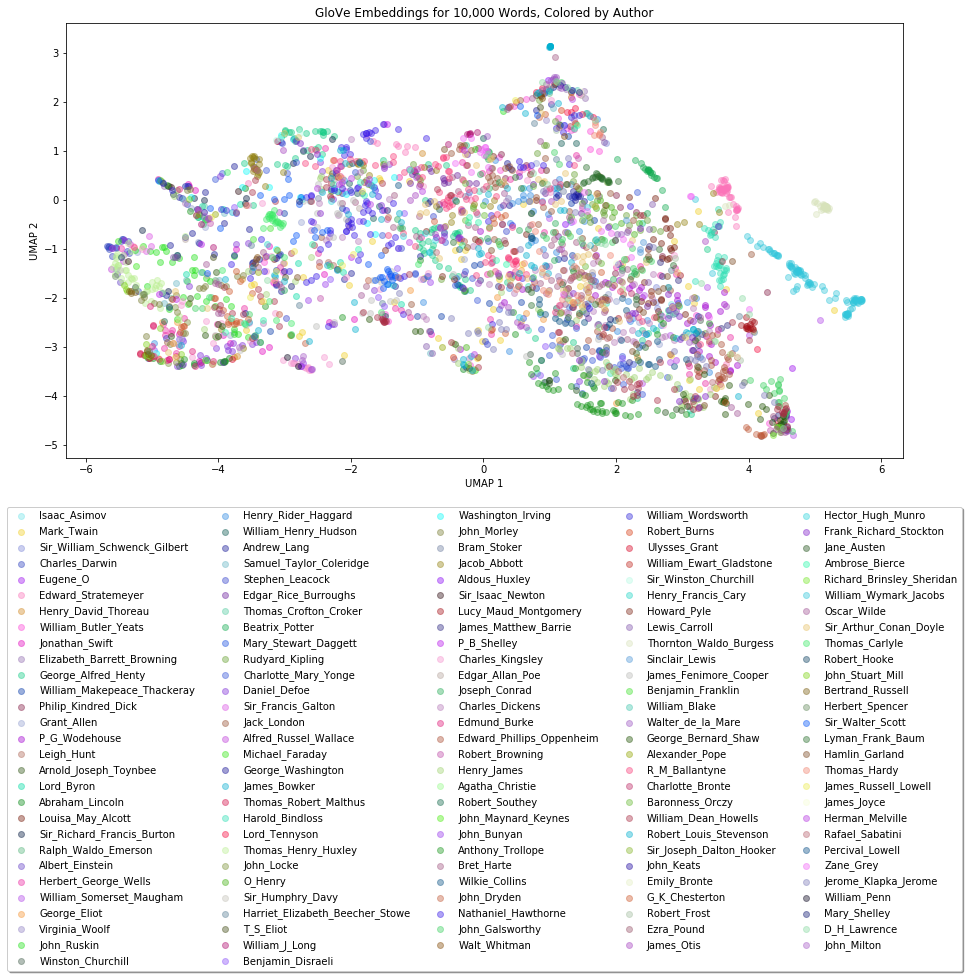

In [7]:
fig = plt.figure(figsize=(15,8))
uniq_labels = np.unique(padded_labels)
for label in uniq_labels:
    author = author_df.loc[author_df['label'] == label, 'author'].values[0]
    label_idx = np.argwhere(padded_labels == label)
    sub_vis_embeddings = vis_embeddings[label_idx, :]
    sub_vis_embeddings = sub_vis_embeddings.reshape(
        sub_vis_embeddings.shape[0]*sub_vis_embeddings.shape[1],
        sub_vis_embeddings.shape[2]
    )
    plt.scatter(
        sub_vis_embeddings[:, 0], 
        sub_vis_embeddings[:, 1], 
        c=np.random.rand(1,3), 
        label=str(author), 
        alpha=0.4
    )

plt.title('GloVe Embeddings for 10,000 Words, Colored by Author')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10),
          fancybox=True, shadow=True, ncol=5)
plt.show()

In [8]:
author_label_df = pd.read_csv('../preprocessing/author_work.csv')
author_label_df['umap_1'] = vis_embeddings[:, 0]
author_label_df['umap_2'] = vis_embeddings[:, 1]
author_label_df.head(10)

author_id_label        author  \
0                0  Isaac_Asimov   
1                1    Mark_Twain   
2                1    Mark_Twain   
3                1    Mark_Twain   
4                1    Mark_Twain   
5                1    Mark_Twain   
6                1    Mark_Twain   
7                1    Mark_Twain   
8                1    Mark_Twain   
9                1    Mark_Twain   

                                              work    umap_1    umap_2  
0                                            Youth  2.834863 -2.124092  
1                            Tom_Sawyer,_Detective  3.661880 -1.814530  
2                                      Roughing_It -2.780130 -2.788750  
3                                   A_Tramp_Abroad -2.030640 -1.741340  
4                             Is_Shakespeare_Dead? -3.509093 -1.733915  
5                                Christian_Science -3.583717 -2.669145  
6              Fenimore_Cooper's_Literary_Offences -2.727886 -1.573633  
7                 On_the_Decay_of_the_Art_of_Lying -2.099604 -3.175798  
8                Life_On_The_Mississippi,_Complete -1.121268  0.381659  
9  Personal_Recollections_of_Joan_of_Arc,_Volume_1 -0.285986 -1.036992

### Plotly Interactive Scatter Plot

In [9]:
fig = px.scatter(author_label_df, x='umap_1', y='umap_2', color='author',
                 hover_data=['work'])
fig.show()

# Nearest Neighbors for Works

### Neighbors Search on 100-D Embeddings

In [10]:
# build data frame with neighbor, author, work
neighbors = NearestNeighbors(n_neighbors=11, metric='cosine').fit(embeddings)
distances, inds = neighbors.kneighbors(embeddings)
full_neighbors = []
for idx in range(inds.shape[0]):
    sub_inds = inds[idx, :].tolist()
    df_author_and_works = author_label_df.iloc[sub_inds, 1:3]
    authors = df_author_and_works['author'].values
    works = df_author_and_works['work'].values
    authors_and_works = np.column_stack((works, authors)).tolist()
    row_neighbors = []
    for row in authors_and_works:
        row_neighbors.extend(row)
      
    full_neighbors.append(row_neighbors)

#random.shuffle(full_neighbors)
df_neighbors = pd.DataFrame(
    full_neighbors,
    columns=[
        'Query_Title', 'Query_Author',
        '1st_Match_Title', '1st_Match_Author',
        '2nd_Match_Title', '2nd_Match_Author',
        '3rd_Match_Title', '3rd_Match_Author',
        '4th_Match_Title', '4th_Match_Author',
        '5th_Match_Title', '5th_Match_Author',
        '6th_Match_Title', '6th_Match_Author',
        '7th_Match_Title', '7th_Match_Author',
        '8th_Match_Title', '8th_Match_Author',
        '9th_Match_Title', '9th_Match_Author',
        '10th_Match_Title', '10th_Match_Author',
    ]
)
#df_neighbors.head(20)
df_neighbors.sort_values(by=['Query_Title'], ascending=False).head(30)

Query_Title           Query_Author  \
1745                                yo             Bret_Harte   
0                                Youth           Isaac_Asimov   
1370                             Youth          Joseph_Conrad   
83           Young_Hunters_of_the_Lake     Edward_Stratemeyer   
856       Young_Folks'_History_of_Rome   Charlotte_Mary_Yonge   
890    Young_Folks'_History_of_England   Charlotte_Mary_Yonge   
78                   Young_Auctioneers     Edward_Stratemeyer   
2094                You_Never_Can_Tell    George_Bernard_Shaw   
1325                  Yeast:_A_Problem       Charles_Kingsley   
1059                             Yeast    Thomas_Henry_Huxley   
1239                            Xerxes           Jacob_Abbott   
1041                     Wyndham's_Pal        Harold_Bindloss   
2026                         Wyandotte  James_Fenimore_Cooper   
2395                 Wuthering_Heights           Emily_Bronte   
273                     Wulf_the_Saxon    George_Alfred_Henty   
2522                    Write_It_Right         Ambrose_Bierce   
2186            Wrecked_but_not_Ruined         R_M_Ballantyne   
410        Work:_A_Story_of_Experience      Louisa_May_Alcott   
2796       Woodstock;_or,_The_Cavalier       Sir_Walter_Scott   
1144               Wood_Folk_at_School         William_J_Long   
248                   Won_by_the_Sword    George_Alfred_Henty   
3029                     Women_in_Love           D_H_Lawrence   
1326                Women_and_Politics       Charles_Kingsley   
1167  Wolfert's_Roost_and_Miscellanies      Washington_Irving   
1373                  Within_the_Tides          Joseph_Conrad   
1588   Within_the_Rim_and_Other_Essays            Henry_James   
214               With_Wolfe_in_Canada    George_Alfred_Henty   
838                With_The_Night_Mail        Rudyard_Kipling   
224              With_Moore_At_Corunna    George_Alfred_Henty   
265               With_Lee_in_Virginia    George_Alfred_Henty   

                                   1st_Match_Title        1st_Match_Author  \
1745                                    Precaution   James_Fenimore_Cooper   
0     The_Rudder_Grangers_Abroad_and_Other_Stories  Frank_Richard_Stockton   
1370                                       Typhoon           Joseph_Conrad   
83                         Out_with_Gun_and_Camera      Edward_Stratemeyer   
856      Aunt_Charlotte's_Stories_of_Greek_History    Charlotte_Mary_Yonge   
890                   A_Child's_History_of_England         Charles_Dickens   
78                 The_Boy_Ranchers_of_Puget_Sound         Harold_Bindloss   
2094                               The_Philanderer     George_Bernard_Shaw   
1325                                 Father_Damien  Robert_Louis_Stevenson   
1059       The_Present_Condition_of_Organic_Nature     Thomas_Henry_Huxley   
1239                              Darius_the_Great            Jacob_Abbott   
1041                      Lister's_Great_Adventure         Harold_Bindloss   
2026          Letters_On_Demonology_And_Witchcraft        Sir_Walter_Scott   
2395                              Jude_the_Obscure            Thomas_Hardy   
273                                   At_Agincourt     George_Alfred_Henty   
2522            Utopia_of_Usurers_and_other_Essays          G_K_Chesterton   
2186                              Jarwin_and_Cuffy          R_M_Ballantyne   
410                                  Rose_in_Bloom       Louisa_May_Alcott   
2796                                 The_Betrothed        Sir_Walter_Scott   
1144                               Wilderness_Ways          William_J_Long   
248                               A_Jacobite_Exile     George_Alfred_Henty   
3029                               The_Dark_Flower         John_Galsworthy   
1326       Sanitary_and_Social_Lectures_and_Essays        Charles_Kingsley   
1167                   Chronicles_of_the_Canongate        Sir_Walter_Scott   
1373                             'Twixt_Land_&_Sea           

### Neighbors Search on UMAP Embeddings, Euclidean Metric

In [11]:
umap_embs = author_label_df[['umap_1', 'umap_2']].values.tolist()
neighbors = NearestNeighbors(n_neighbors=11, metric='euclidean').fit(umap_embs)
distances, inds = neighbors.kneighbors(umap_embs)
full_neighbors = []
for idx in range(inds.shape[0]):
    sub_inds = inds[idx, :].tolist()
    df_author_and_works = author_label_df.iloc[sub_inds, 1:3]
    authors = df_author_and_works['author'].values
    works = df_author_and_works['work'].values
    authors_and_works = np.column_stack((works, authors)).tolist()
    row_neighbors = []
    for row in authors_and_works:
        row_neighbors.extend(row)
      
    full_neighbors.append(row_neighbors)

#random.shuffle(full_neighbors)
df_neighbors = pd.DataFrame(
    full_neighbors,
    columns=[
        'Query_Title', 'Query_Author',
        '1st_Match_Title', '1st_Match_Author',
        '2nd_Match_Title', '2nd_Match_Author',
        '3rd_Match_Title', '3rd_Match_Author',
        '4th_Match_Title', '4th_Match_Author',
        '5th_Match_Title', '5th_Match_Author',
        '6th_Match_Title', '6th_Match_Author',
        '7th_Match_Title', '7th_Match_Author',
        '8th_Match_Title', '8th_Match_Author',
        '9th_Match_Title', '9th_Match_Author',
        '10th_Match_Title', '10th_Match_Author',
    ]
)
#df_neighbors.head(30)
df_neighbors.sort_values(by=['Query_Title'], ascending=False).head(30)

Query_Title           Query_Author  \
1745                                yo             Bret_Harte   
0                                Youth           Isaac_Asimov   
1370                             Youth          Joseph_Conrad   
83           Young_Hunters_of_the_Lake     Edward_Stratemeyer   
856       Young_Folks'_History_of_Rome   Charlotte_Mary_Yonge   
890    Young_Folks'_History_of_England   Charlotte_Mary_Yonge   
78                   Young_Auctioneers     Edward_Stratemeyer   
2094                You_Never_Can_Tell    George_Bernard_Shaw   
1325                  Yeast:_A_Problem       Charles_Kingsley   
1059                             Yeast    Thomas_Henry_Huxley   
1239                            Xerxes           Jacob_Abbott   
1041                     Wyndham's_Pal        Harold_Bindloss   
2026                         Wyandotte  James_Fenimore_Cooper   
2395                 Wuthering_Heights           Emily_Bronte   
273                     Wulf_the_Saxon    George_Alfred_Henty   
2522                    Write_It_Right         Ambrose_Bierce   
2186            Wrecked_but_not_Ruined         R_M_Ballantyne   
410        Work:_A_Story_of_Experience      Louisa_May_Alcott   
2796       Woodstock;_or,_The_Cavalier       Sir_Walter_Scott   
1144               Wood_Folk_at_School         William_J_Long   
248                   Won_by_the_Sword    George_Alfred_Henty   
3029                     Women_in_Love           D_H_Lawrence   
1326                Women_and_Politics       Charles_Kingsley   
1167  Wolfert's_Roost_and_Miscellanies      Washington_Irving   
1373                  Within_the_Tides          Joseph_Conrad   
1588   Within_the_Rim_and_Other_Essays            Henry_James   
214               With_Wolfe_in_Canada    George_Alfred_Henty   
838                With_The_Night_Mail        Rudyard_Kipling   
224              With_Moore_At_Corunna    George_Alfred_Henty   
265               With_Lee_in_Virginia    George_Alfred_Henty   

                                        1st_Match_Title  \
1745                     Dryden's_Works_Vol._16_(of_18)   
0          The_Rudder_Grangers_Abroad_and_Other_Stories   
1370                      The_Nigger_Of_The_"Narcissus"   
83                              First_at_the_North_Pole   
856                           The_Life_of_Cesare_Borgia   
890                                           Cleopatra   
78                                   Lightfoot_the_Deer   
2094                                      The_Skin_Game   
1325                                           Phaethon   
1059  The_Interpreters_of_Genesis_and_the_Interprete...   
1239                                           Hannibal   
1041                      What_Might_Have_Been_Expected   
2026  Notes_to_the_Complete_Poetical_Works_of_Percy_...   
2395  The_Works_of_Robert_Louis_Stevenson_-_Swanston...   
273               Personal_Reminiscences_in_Book_Making   
2522                 Utopia_of_Usurers_and_other_Essays   
2186                                   Messenger_No._48   
410                                            Berenice   
2796                                      Old_Mortality   
1144                                Secret_of_the_Woods   
248                        With_Kitchener_in_the_Soudan   
3029                                    The_Dark_Flower   
1326                             An_Essay_Upon_Projects   
1167              History_of_King_Charles_II_of_England   
1373                           The_History_of_Mr._Polly   
1588           The_Doctor's_Dilemma:_Preface_on_Doctors   
214                             Beasts_and_Super-Beasts   
838                 Noto,_An_Unexplored_Corner_of_Japan   
224                              The_Lion_of_Saint_Mark   
265                           The_Treasure_of_the_Incas   

               1st_Match_Author  \
1745                John_Dryden   
0        Frank_Richard_Stockton   
1370              Joseph_Conrad   
83           Edward_Stratemeyer   
856   

### Neighbors Search on UMAP Embeddings, Cosine Metric

In [12]:
umap_embs = author_label_df[['umap_1', 'umap_2']].values.tolist()
neighbors = NearestNeighbors(n_neighbors=11, metric='cosine').fit(umap_embs)
distances, inds = neighbors.kneighbors(umap_embs)
full_neighbors = []
for idx in range(inds.shape[0]):
    sub_inds = inds[idx, :].tolist()
    df_author_and_works = author_label_df.iloc[sub_inds, 1:3]
    authors = df_author_and_works['author'].values
    works = df_author_and_works['work'].values
    authors_and_works = np.column_stack((works, authors)).tolist()
    row_neighbors = []
    for row in authors_and_works:
        row_neighbors.extend(row)
      
    full_neighbors.append(row_neighbors)

#random.shuffle(full_neighbors)
df_neighbors = pd.DataFrame(
    full_neighbors,
    columns=[
        'Query_Title', 'Query_Author',
        '1st_Match_Title', '1st_Match_Author',
        '2nd_Match_Title', '2nd_Match_Author',
        '3rd_Match_Title', '3rd_Match_Author',
        '4th_Match_Title', '4th_Match_Author',
        '5th_Match_Title', '5th_Match_Author',
        '6th_Match_Title', '6th_Match_Author',
        '7th_Match_Title', '7th_Match_Author',
        '8th_Match_Title', '8th_Match_Author',
        '9th_Match_Title', '9th_Match_Author',
        '10th_Match_Title', '10th_Match_Author',
    ]
)
#df_neighbors.head(30)
df_neighbors.sort_values(by=['Query_Title'], ascending=False).head(30)

Query_Title           Query_Author  \
1745                                yo             Bret_Harte   
0                                Youth           Isaac_Asimov   
1370                             Youth          Joseph_Conrad   
83           Young_Hunters_of_the_Lake     Edward_Stratemeyer   
856       Young_Folks'_History_of_Rome   Charlotte_Mary_Yonge   
890    Young_Folks'_History_of_England   Charlotte_Mary_Yonge   
78                   Young_Auctioneers     Edward_Stratemeyer   
2094                You_Never_Can_Tell    George_Bernard_Shaw   
1325                  Yeast:_A_Problem       Charles_Kingsley   
1059                             Yeast    Thomas_Henry_Huxley   
1239                            Xerxes           Jacob_Abbott   
1041                     Wyndham's_Pal        Harold_Bindloss   
2026                         Wyandotte  James_Fenimore_Cooper   
2395                 Wuthering_Heights           Emily_Bronte   
273                     Wulf_the_Saxon    George_Alfred_Henty   
2522                    Write_It_Right         Ambrose_Bierce   
2186            Wrecked_but_not_Ruined         R_M_Ballantyne   
410        Work:_A_Story_of_Experience      Louisa_May_Alcott   
2796       Woodstock;_or,_The_Cavalier       Sir_Walter_Scott   
1144               Wood_Folk_at_School         William_J_Long   
248                   Won_by_the_Sword    George_Alfred_Henty   
3029                     Women_in_Love           D_H_Lawrence   
1326                Women_and_Politics       Charles_Kingsley   
1167  Wolfert's_Roost_and_Miscellanies      Washington_Irving   
1373                  Within_the_Tides          Joseph_Conrad   
1588   Within_the_Rim_and_Other_Essays            Henry_James   
214               With_Wolfe_in_Canada    George_Alfred_Henty   
838                With_The_Night_Mail        Rudyard_Kipling   
224              With_Moore_At_Corunna    George_Alfred_Henty   
265               With_Lee_in_Virginia    George_Alfred_Henty   

                                        1st_Match_Title  \
1745                             Essays_on_Paul_Bourget   
0                                The_Intrusion_of_Jimmy   
1370                               The_Prussian_Officer   
83                                        Pepper_&_Salt   
856                   Cetywayo_and_his_White_Neighbours   
890                              A_Book_of_Golden_Deeds   
78                                   Rollo_in_the_Woods   
2094                              The_Making_of_a_Saint   
1325                  The_Poetical_Works_of_John_Milton   
1059                              The_Mirror_of_the_Sea   
1239                                      France_At_War   
1041                           Lister's_Great_Adventure   
2026                               Richard_of_Jamestown   
2395                           Jeff_Briggs's_Love_Story   
273                                                  yo   
2522                      The_House_of_the_Seven_Gables   
2186                                     Down_the_Slope   
410   The_O'Conors_of_Castle_Conor_from_Tales_from_a...   
2796                                      Paradise_Lost   
1144                                       The_Refugees   
248                    The_History_of_Henry_Esmond,_Esq   
3029                                    Peter_and_Wendy   
1326                        Indian_speeches_(1907-1909)   
1167  Our_Fathers_Have_Told_Us,_Part_I,_The_Bible_of...   
1373                                  Fifty_Bab_Ballads   
1588                                           New_York   
214                              North_America_Volume_1   
838   By_Pike_and_Dyke:__A_Tale_of_the_Rise_of_the_D...   
224   The_History_of_the_Life_and_Adventures_of_Mr._...   
265                       In_Defense_of_Harriet_Shelley   

                  1st_Match_Author  \
1745                    Mark_Twain   
0                    P_G_Wodehouse   
1370                  D_H_Lawrence   
83                     Howard